In [ ]:
#!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [1]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/distan_lat43.302lon-8.377p4R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

Weather frequencies


M                  83.07%
-RA                 4.35%
BCFG                2.48%
FG                  1.87%
BR                  1.35%
RA                  1.30%
-DZ                 0.75%
-RA BR              0.57%
VCFG                0.55%
SHRA                0.48%
-SHRA               0.33%
BR BCFG             0.33%
PRFG                0.28%
RA BR               0.24%
DZ                  0.19%
-DZ BR              0.13%
-RA BCFG            0.13%
VCSH                0.12%
-RADZ               0.11%
+RA                 0.09%
FZFG                0.08%
+SHRA               0.07%
-DZ BCFG            0.06%
VCTS                0.06%
BCFG MIFG           0.05%
MIFG                0.05%
BR -DZ              0.04%
RA BCFG             0.04%
BCFG -DZ            0.04%
-RA BR BCFG         0.04%
RADZ                0.03%
PRFG BCFG           0.03%
-RA FG              0.03%
DZ BR               0.03%
SHGR                0.03%
BR -RA              0.03%
BCFG BR             0.02%
BR DZ               0.02%
+RA BR      

*****************************
Climatology RA or DZ


No RA/DZ    91%
RA/DZ        9%
Name: prec_l, dtype: object

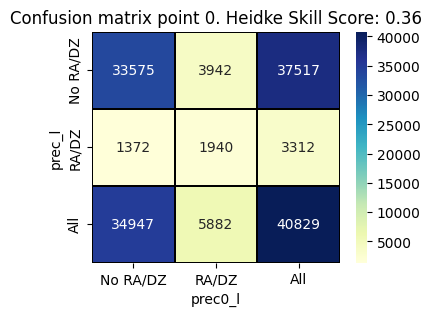

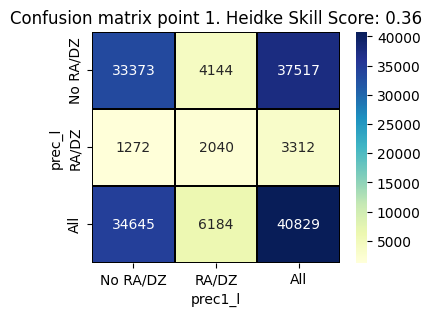

Chi2 contingency test

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 5698.505452175477
Reject H0,There is an association between meteorological model forecast and observed values


In [9]:
#@title Load station (visibility). Load meteorological model forecast D0. Display relation visibility with model variables. Heidke skill score (HSS) meteorological model 
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/LECOY2018Y2022.csv",
                          usecols =["time","wxcodes_o"],
                          parse_dates=["time"]).dropna().set_index("time")

print("Weather frequencies")
display(station["wxcodes_o"].value_counts(normalize=True).map(lambda n: '{:.2%}'.format(n)))

station["prec_l"] = "No RA/DZ"
mask = station['wxcodes_o'].str.contains("RA")
station.loc[mask,["prec_l"]] = "RA/DZ"
mask = station['wxcodes_o'].str.contains("DZ")
station.loc[mask,["prec_l"]] = "RA/DZ"
station["prec_l"]=pd.Categorical(station["prec_l"])

#display(station.sample(50).head(20))
print("*****************************")
print("Climatology RA or DZ")
display(station["prec_l"].value_counts(normalize=True).map(lambda n: '{:.0%}'.format(n)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).dropna()
#display(df_all)


#label meteorological model variables prec0 and prec1
df_all["prec0_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec0]))
df_all["prec1_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec1]))

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.prec_l, df_all.prec0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

                                   
cm1 = pd.crosstab(df_all.prec_l, df_all.prec1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between meteorological model forecast and observed values")
else:
    print("Retain H0,There is no association between meteorological model and observed values")


Round 0


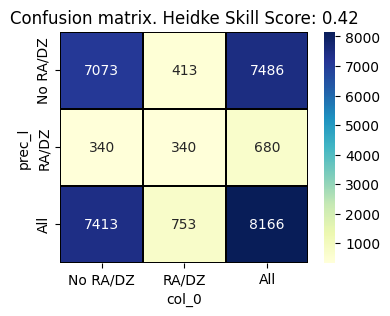

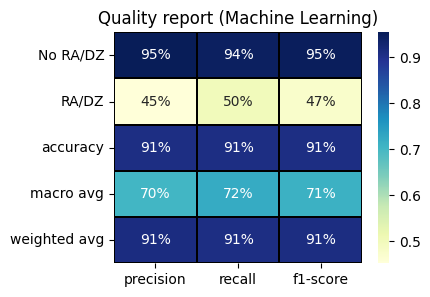

,feature,feature_per
102,dayofyear,3.0%
100,hour,2.9%
43,cfl1,1.8%
91,cin3,1.7%
101,month,1.7%
37,prec1,1.7%
17,cfh0,1.7%
62,prec2,1.5%
16,cin0,1.5%
93,cfl3,1.5%


Round 1


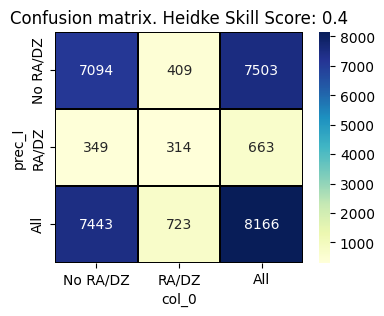

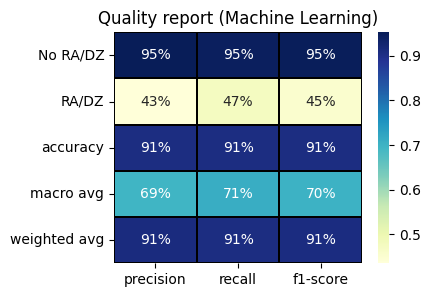

,feature,feature_per
102,dayofyear,3.0%
100,hour,2.8%
95,cft3,1.8%
0,dir0,1.8%
93,cfl3,1.7%
16,cin0,1.7%
92,cfh3,1.7%
42,cfh1,1.6%
37,prec1,1.6%
75,dir3,1.5%


Round 2


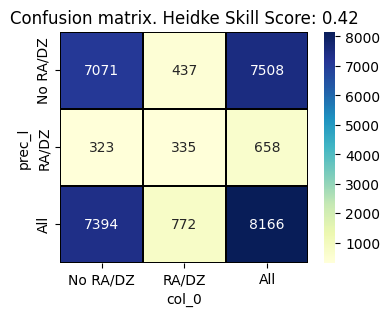

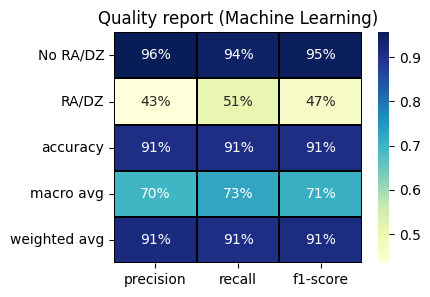

,feature,feature_per
100,hour,2.9%
102,dayofyear,2.7%
92,cfh3,2.1%
37,prec1,1.8%
0,dir0,1.7%
93,cfl3,1.5%
25,dir1,1.5%
67,cfh2,1.5%
101,month,1.5%
95,cft3,1.5%


Round 3


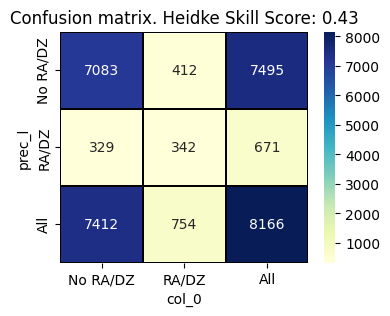

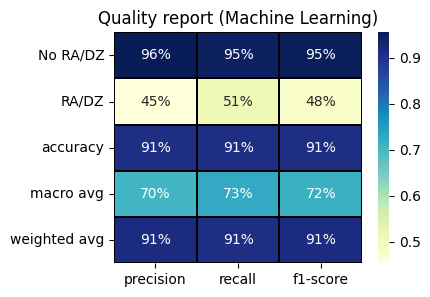

,feature,feature_per
102,dayofyear,3.0%
100,hour,2.8%
92,cfh3,2.2%
93,cfl3,1.9%
101,month,1.8%
95,cft3,1.7%
16,cin0,1.7%
45,cft1,1.7%
17,cfh0,1.7%
75,dir3,1.6%


Round 4


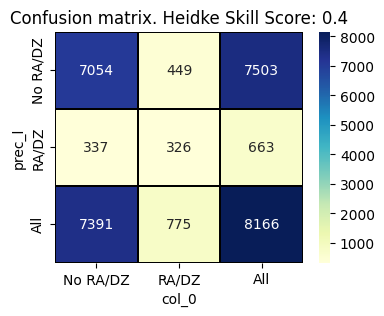

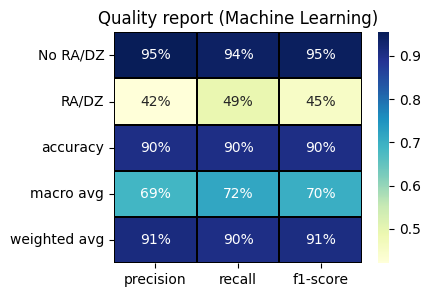

,feature,feature_per
102,dayofyear,3.0%
100,hour,2.9%
17,cfh0,2.0%
37,prec1,1.7%
75,dir3,1.6%
20,cft0,1.6%
43,cfl1,1.6%
101,month,1.5%
95,cft3,1.5%
93,cfl3,1.5%


Round 5


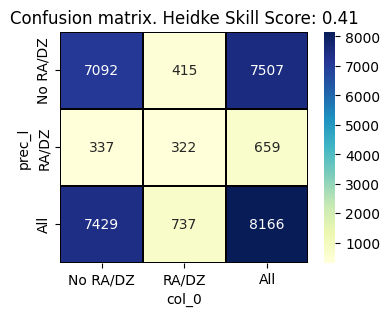

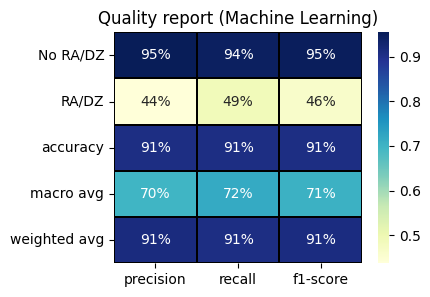

,feature,feature_per
100,hour,2.9%
102,dayofyear,2.5%
92,cfh3,2.0%
17,cfh0,2.0%
20,cft0,1.9%
0,dir0,1.9%
95,cft3,1.6%
12,prec0,1.6%
67,cfh2,1.6%
7,rh0,1.5%


Round 6


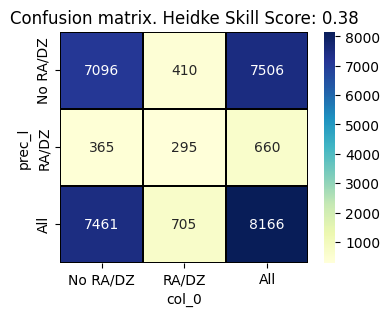

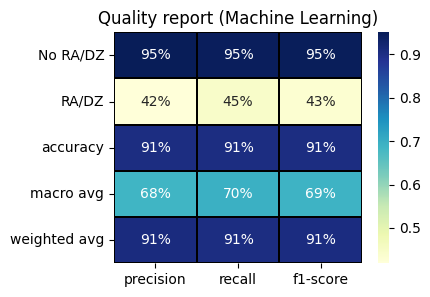

,feature,feature_per
102,dayofyear,2.9%
100,hour,2.8%
92,cfh3,2.1%
37,prec1,2.0%
17,cfh0,1.9%
95,cft3,1.7%
93,cfl3,1.6%
45,cft1,1.6%
43,cfl1,1.6%
62,prec2,1.6%


Round 7


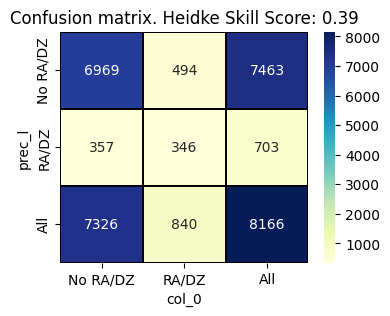

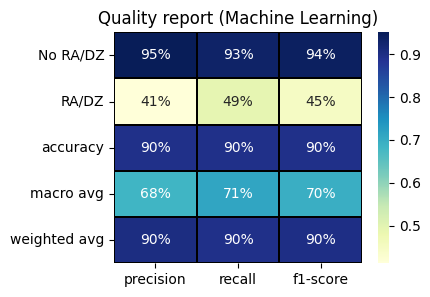

,feature,feature_per
100,hour,2.9%
102,dayofyear,2.8%
95,cft3,1.9%
92,cfh3,1.9%
37,prec1,1.8%
43,cfl1,1.6%
32,rh1,1.6%
75,dir3,1.6%
17,cfh0,1.5%
16,cin0,1.5%


Round 8


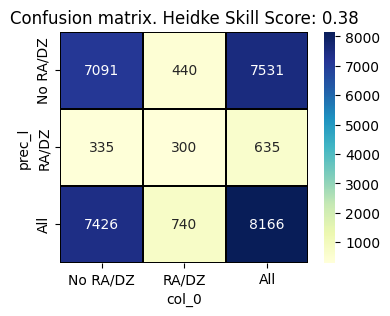

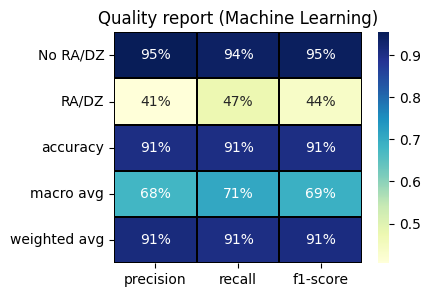

,feature,feature_per
102,dayofyear,3.2%
100,hour,2.5%
67,cfh2,2.1%
92,cfh3,1.9%
44,cfm1,1.8%
60,lwflx2,1.7%
101,month,1.6%
93,cfl3,1.6%
66,cin2,1.6%
0,dir0,1.5%


Round 9


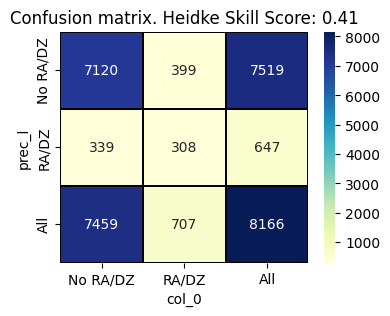

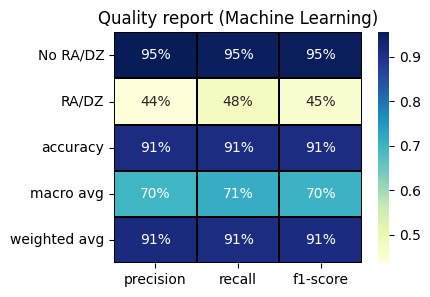

,feature,feature_per
102,dayofyear,3.0%
100,hour,2.6%
92,cfh3,1.8%
93,cfl3,1.7%
101,month,1.7%
62,prec2,1.7%
45,cft1,1.6%
25,dir1,1.6%
75,dir3,1.6%
0,dir0,1.6%



HSS stadistics
             HSS
count  10.000000
mean    0.404972
std     0.016433
min     0.380515
25%     0.393822
50%     0.404136
75%     0.416200
max     0.430477
Shapiro test normality
p value: 0.9164621233940125
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 6.889632207442657e-294
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1342.4047116245267
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 2.42 minutes


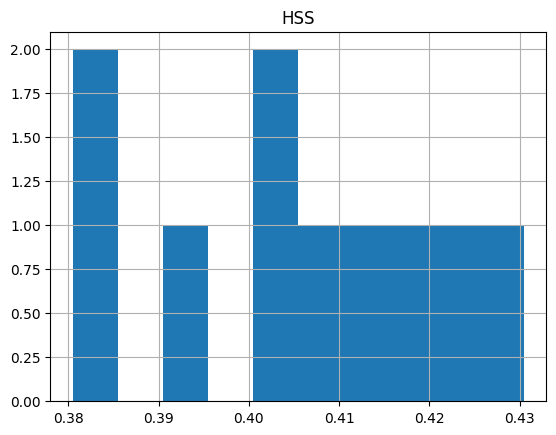

In [13]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro


start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int) 

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])
 

# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()
  
  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage) 
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples") 



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [16]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/prec_LECO_d0.al", 'wb'))

Round 0


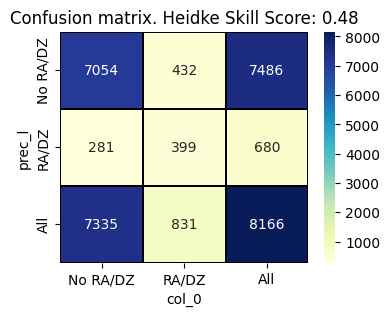

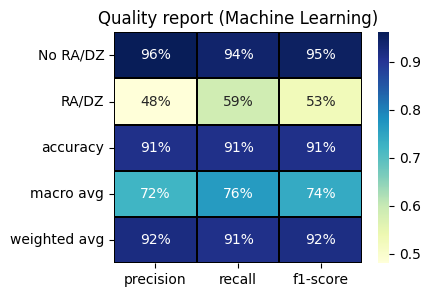

,feature,feature_per
44,cfm1,3.6%
95,cft3,3.4%
94,cfm3,3.4%
69,cfm2,3.4%
93,cfl3,3.3%
20,cft0,3.3%
18,cfl0,3.0%
43,cfl1,2.5%
68,cfl2,2.4%
45,cft1,2.3%


Round 1


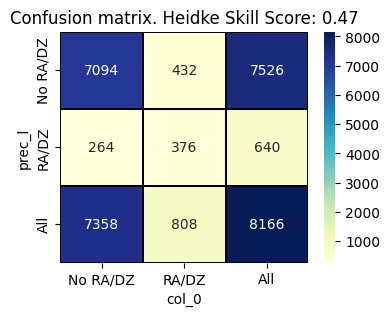

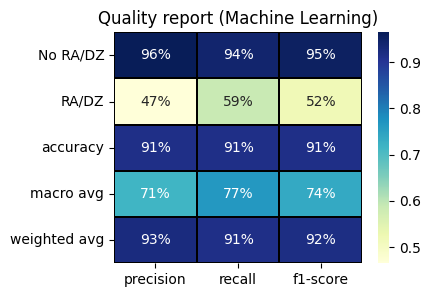

,feature,feature_per
18,cfl0,4.1%
44,cfm1,3.7%
43,cfl1,3.3%
19,cfm0,3.2%
45,cft1,3.1%
93,cfl3,2.5%
94,cfm3,2.4%
20,cft0,2.4%
95,cft3,2.1%
69,cfm2,2.0%


Round 2


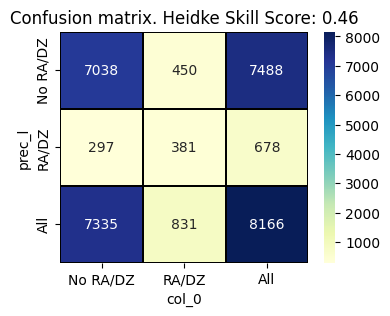

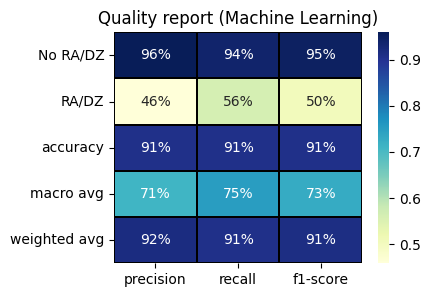

,feature,feature_per
43,cfl1,4.2%
44,cfm1,3.7%
18,cfl0,3.3%
95,cft3,3.3%
68,cfl2,2.8%
93,cfl3,2.8%
94,cfm3,2.6%
20,cft0,2.3%
69,cfm2,2.3%
19,cfm0,2.1%


Round 3


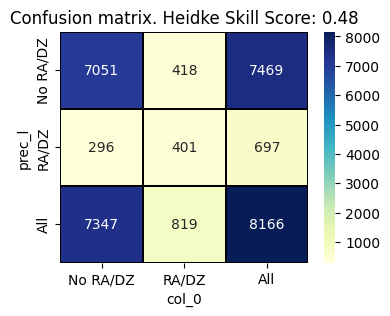

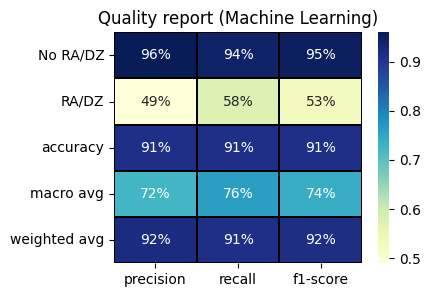

,feature,feature_per
68,cfl2,3.7%
20,cft0,3.1%
19,cfm0,3.0%
95,cft3,3.0%
18,cfl0,2.8%
43,cfl1,2.7%
94,cfm3,2.5%
44,cfm1,2.5%
45,cft1,2.3%
93,cfl3,2.3%


Round 4


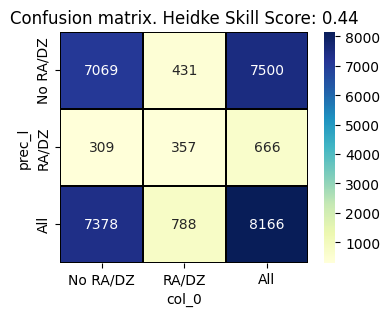

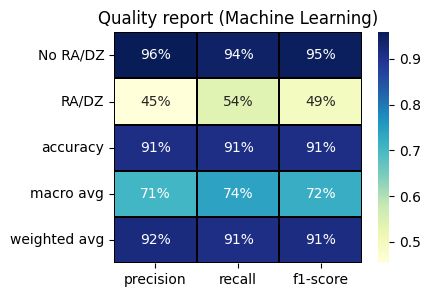

,feature,feature_per
45,cft1,3.4%
18,cfl0,3.4%
68,cfl2,3.2%
69,cfm2,3.0%
93,cfl3,3.0%
94,cfm3,3.0%
43,cfl1,2.8%
44,cfm1,2.5%
19,cfm0,2.4%
70,cft2,2.3%


Round 5


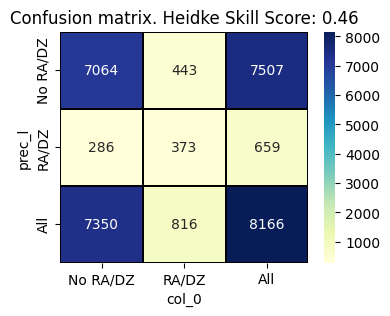

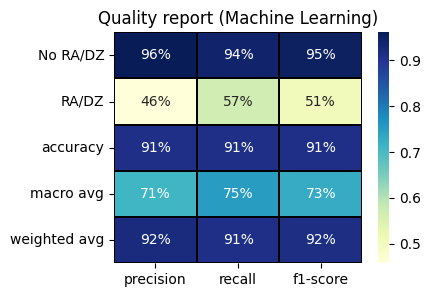

,feature,feature_per
19,cfm0,3.5%
94,cfm3,3.2%
43,cfl1,3.2%
93,cfl3,3.2%
18,cfl0,3.1%
69,cfm2,3.0%
95,cft3,2.5%
45,cft1,2.4%
44,cfm1,2.3%
68,cfl2,2.3%


Round 6


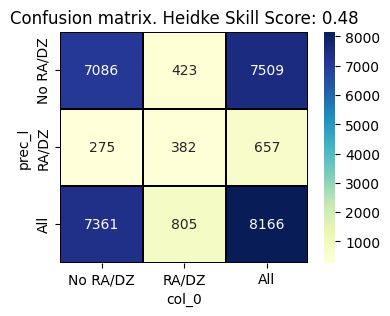

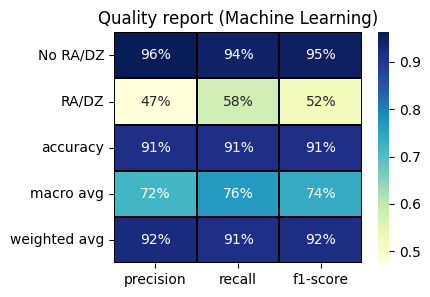

,feature,feature_per
44,cfm1,3.5%
94,cfm3,3.0%
95,cft3,2.9%
45,cft1,2.8%
43,cfl1,2.8%
68,cfl2,2.8%
18,cfl0,2.7%
93,cfl3,2.6%
69,cfm2,2.5%
19,cfm0,2.4%


Round 7


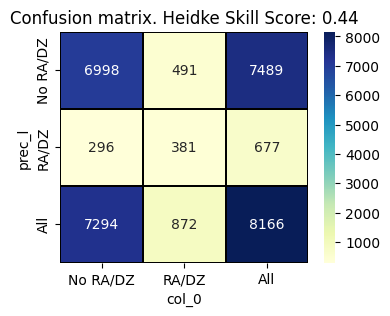

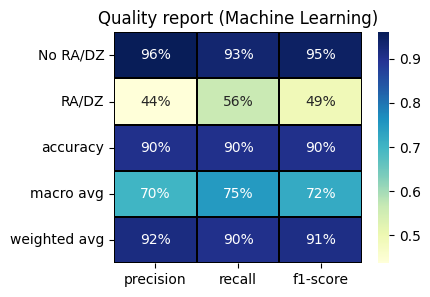

,feature,feature_per
94,cfm3,3.9%
43,cfl1,3.2%
70,cft2,3.0%
45,cft1,2.9%
95,cft3,2.7%
20,cft0,2.7%
44,cfm1,2.6%
93,cfl3,2.6%
68,cfl2,2.5%
18,cfl0,2.5%


Round 8


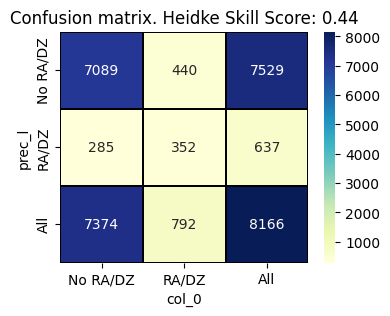

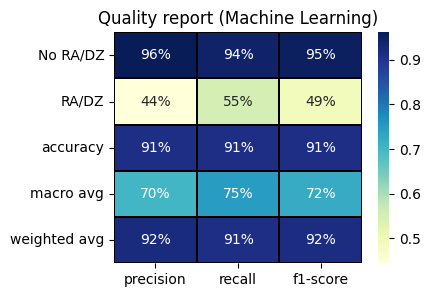

,feature,feature_per
93,cfl3,3.6%
44,cfm1,3.5%
18,cfl0,3.3%
43,cfl1,3.1%
45,cft1,3.0%
94,cfm3,2.6%
68,cfl2,2.4%
95,cft3,2.4%
19,cfm0,2.3%
69,cfm2,2.1%


Round 9


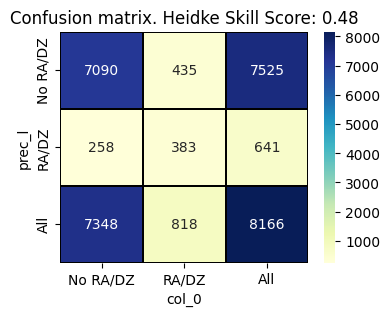

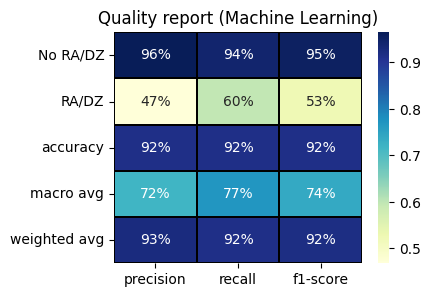

,feature,feature_per
43,cfl1,4.6%
18,cfl0,3.4%
45,cft1,3.0%
68,cfl2,2.8%
20,cft0,2.8%
94,cfm3,2.7%
69,cfm2,2.7%
93,cfl3,2.7%
19,cfm0,2.5%
95,cft3,2.4%



HSS stadistics
             HSS
count  10.000000
mean    0.462874
std     0.017029
min     0.439624
25%     0.447260
50%     0.465285
75%     0.478421
max     0.481176
Shapiro test normality
p value: 0.0669085755944252
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1902.7749158241345
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 4.45 minutes


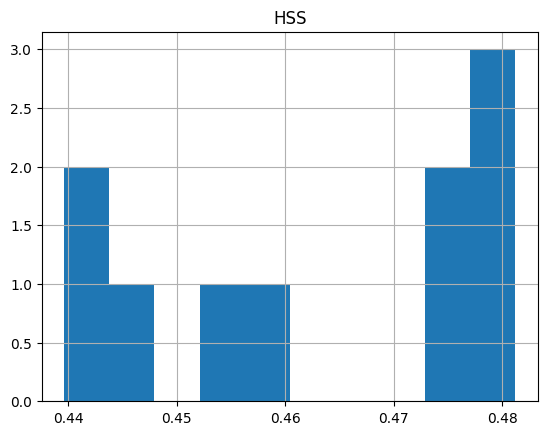

In [17]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()
  
  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage) 
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples") 



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")





  

In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/prec_LECO_d0.al", 'wb'))

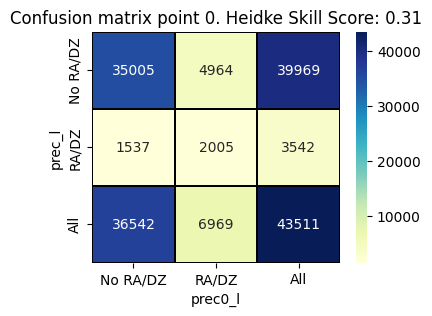

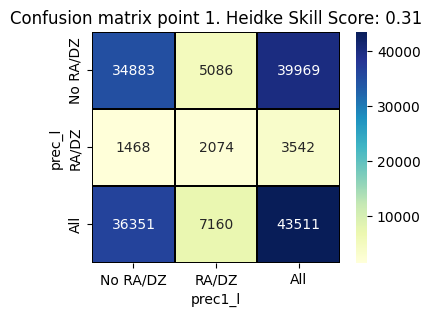

Chi2 contingency test

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 4719.449364774461
Reject H0,There is an association between meteorological model forecast and observed values


In [20]:
#@title Load meteorological model forecast D1.Display relation visibility with model variables. Heidke skill score (HSS) meteorological model 
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LECO/input_files/lat43.302lon-8.377p4R4KmD1Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).dropna()
#display(df_all)


#label meteorological model variables prec0 and prec1
df_all["prec0_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec0]))
df_all["prec1_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec1]))

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.prec_l, df_all.prec0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

                                   
cm1 = pd.crosstab(df_all.prec_l, df_all.prec1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between meteorological model forecast and observed values")
else:
    print("Retain H0,There is no association between meteorological model and observed values")


Round 0


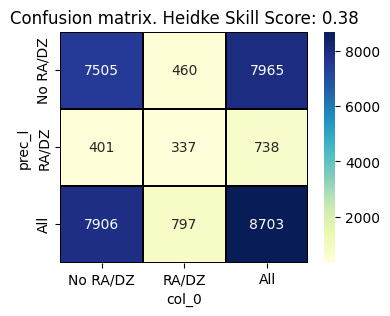

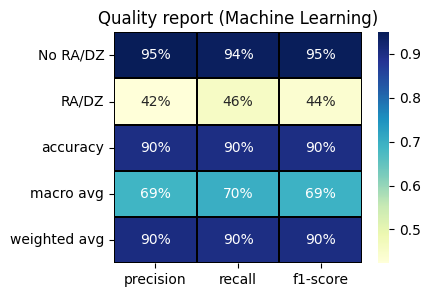

,feature,feature_per
102,dayofyear,3.4%
100,hour,2.6%
17,cfh0,2.6%
62,prec2,2.0%
92,cfh3,1.9%
0,dir0,1.8%
37,prec1,1.7%
43,cfl1,1.6%
75,dir3,1.6%
101,month,1.6%


Round 1


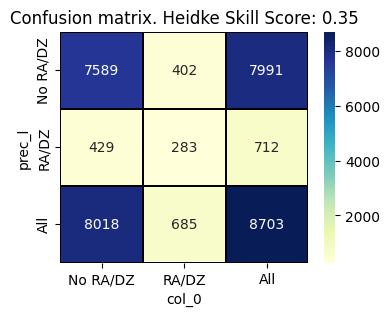

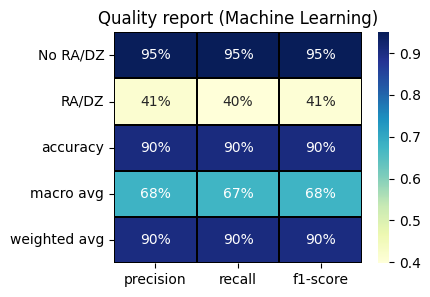

,feature,feature_per
102,dayofyear,3.2%
100,hour,2.5%
17,cfh0,2.2%
0,dir0,1.9%
37,prec1,1.9%
92,cfh3,1.8%
50,dir2,1.7%
75,dir3,1.6%
18,cfl0,1.6%
94,cfm3,1.6%


Round 2


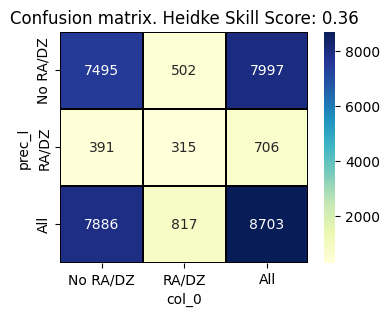

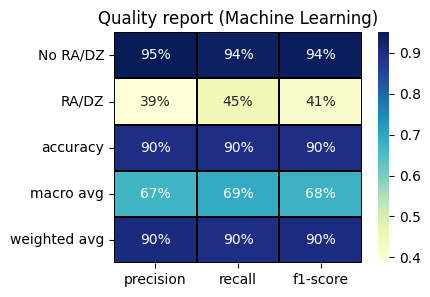

,feature,feature_per
102,dayofyear,3.5%
100,hour,2.7%
17,cfh0,2.4%
37,prec1,1.9%
50,dir2,1.9%
92,cfh3,1.8%
93,cfl3,1.7%
41,cin1,1.5%
18,cfl0,1.5%
94,cfm3,1.5%


Round 3


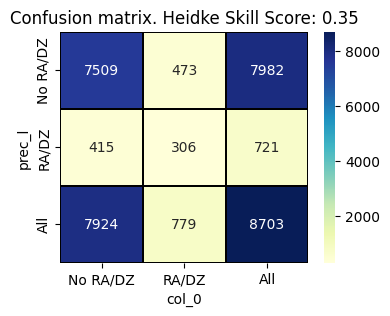

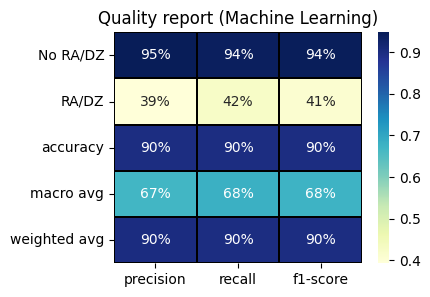

,feature,feature_per
102,dayofyear,3.2%
100,hour,2.4%
17,cfh0,2.4%
37,prec1,2.1%
0,dir0,1.9%
62,prec2,1.8%
50,dir2,1.8%
93,cfl3,1.8%
87,prec3,1.7%
41,cin1,1.7%


Round 4


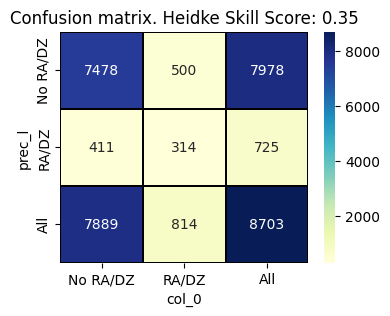

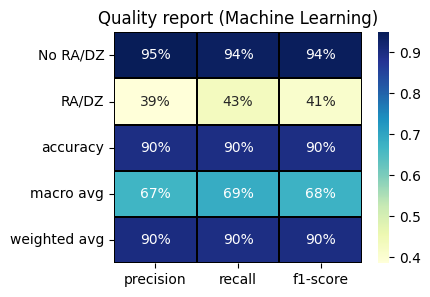

,feature,feature_per
102,dayofyear,3.2%
100,hour,2.5%
37,prec1,2.3%
17,cfh0,2.3%
92,cfh3,2.2%
0,dir0,1.8%
43,cfl1,1.7%
62,prec2,1.7%
50,dir2,1.7%
20,cft0,1.6%


Round 5


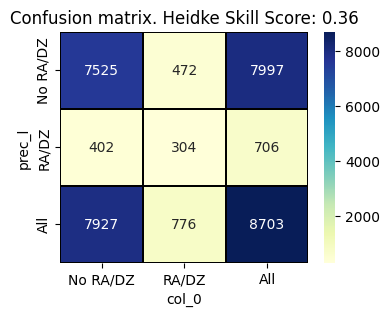

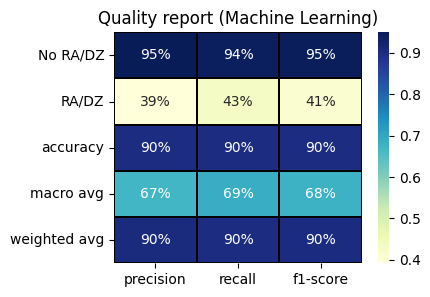

,feature,feature_per
102,dayofyear,3.2%
17,cfh0,3.0%
100,hour,2.9%
37,prec1,2.2%
12,prec0,1.7%
50,dir2,1.7%
94,cfm3,1.6%
101,month,1.6%
25,dir1,1.6%
75,dir3,1.5%


Round 6


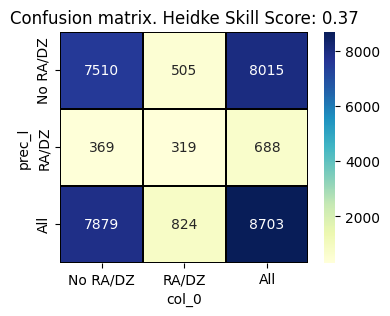

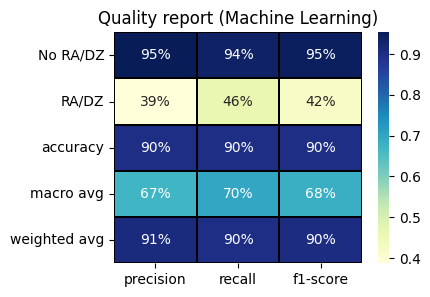

,feature,feature_per
102,dayofyear,3.3%
100,hour,2.8%
17,cfh0,2.2%
37,prec1,2.1%
92,cfh3,2.1%
62,prec2,1.8%
101,month,1.6%
7,rh0,1.6%
94,cfm3,1.6%
50,dir2,1.6%


Round 7


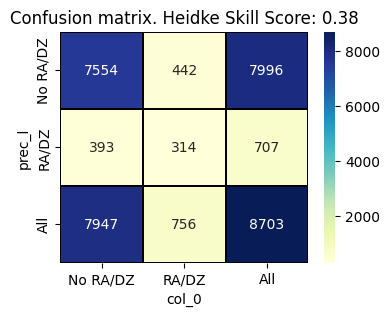

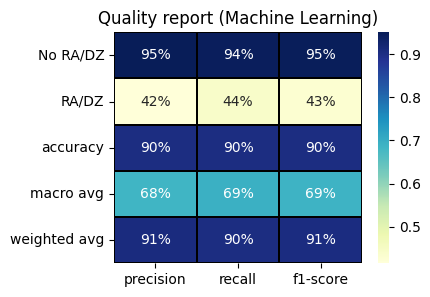

,feature,feature_per
102,dayofyear,3.0%
100,hour,2.8%
17,cfh0,2.6%
62,prec2,1.9%
50,dir2,1.8%
93,cfl3,1.8%
37,prec1,1.7%
20,cft0,1.6%
75,dir3,1.6%
94,cfm3,1.6%


Round 8


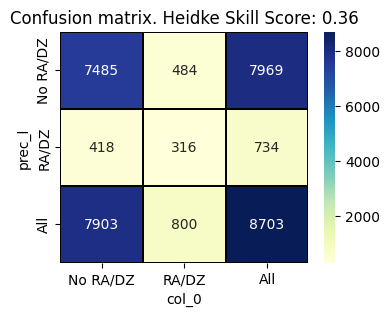

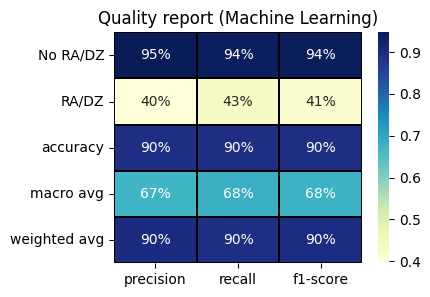

,feature,feature_per
102,dayofyear,3.3%
100,hour,2.8%
17,cfh0,2.2%
50,dir2,2.0%
62,prec2,2.0%
37,prec1,1.8%
75,dir3,1.8%
94,cfm3,1.8%
87,prec3,1.8%
93,cfl3,1.8%


Round 9


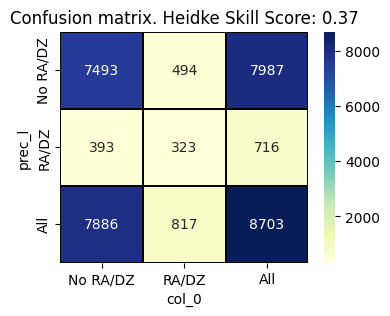

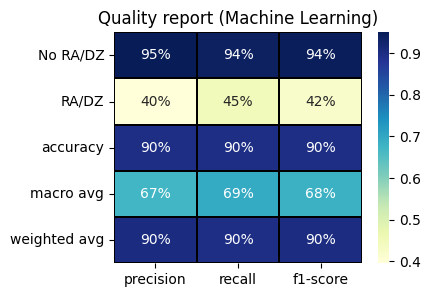

,feature,feature_per
102,dayofyear,2.9%
100,hour,2.8%
17,cfh0,2.4%
50,dir2,2.3%
68,cfl2,1.8%
94,cfm3,1.8%
16,cin0,1.7%
62,prec2,1.6%
92,cfh3,1.6%
87,prec3,1.6%



HSS stadistics
             HSS
count  10.000000
mean    0.362004
std     0.011516
min     0.350853
25%     0.353770
50%     0.356633
75%     0.367037
max     0.384926
Shapiro test normality
p value: 0.08197134733200073
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 1.528110201171392e-255
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1165.9557430245745
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 2.44 minutes


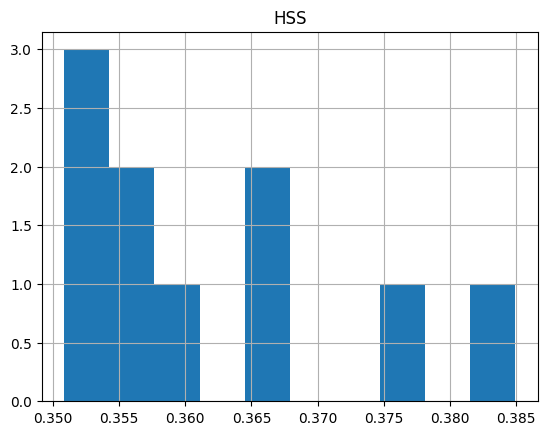

In [21]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score
start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int) 

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])
 

# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()
  
  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage) 
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples") 



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [23]:
#@title Save last algorithm round 9

x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/prec_LECO_d1.al", 'wb'))


Round 0


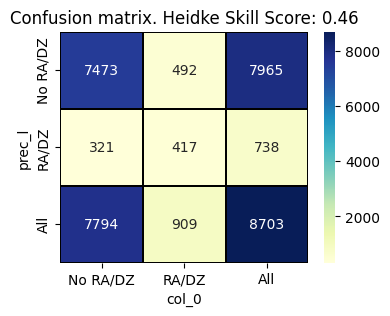

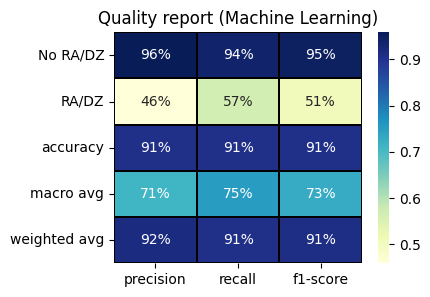

,feature,feature_per
94,cfm3,3.4%
19,cfm0,2.8%
69,cfm2,2.7%
44,cfm1,2.6%
70,cft2,2.6%
45,cft1,2.5%
43,cfl1,2.5%
20,cft0,2.2%
18,cfl0,2.0%
95,cft3,1.9%


Round 1


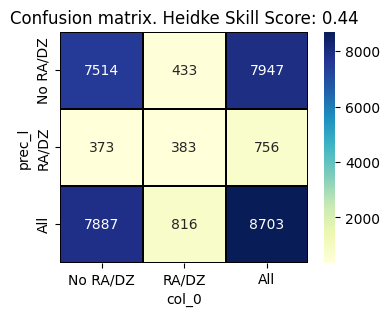

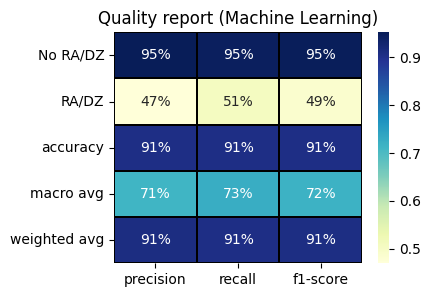

,feature,feature_per
43,cfl1,3.2%
45,cft1,3.0%
94,cfm3,3.0%
44,cfm1,2.7%
69,cfm2,2.3%
20,cft0,2.3%
68,cfl2,2.2%
70,cft2,2.1%
93,cfl3,1.9%
19,cfm0,1.9%


Round 2


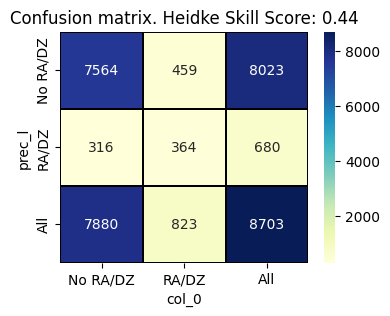

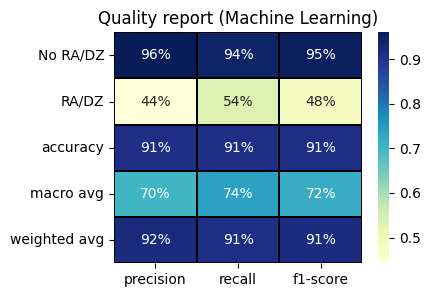

,feature,feature_per
45,cft1,3.0%
43,cfl1,2.8%
18,cfl0,2.8%
19,cfm0,2.7%
44,cfm1,2.6%
94,cfm3,2.5%
93,cfl3,2.5%
20,cft0,2.3%
69,cfm2,2.3%
70,cft2,2.1%


Round 3


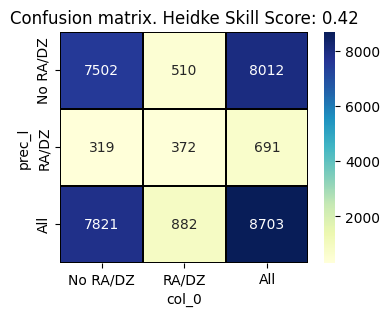

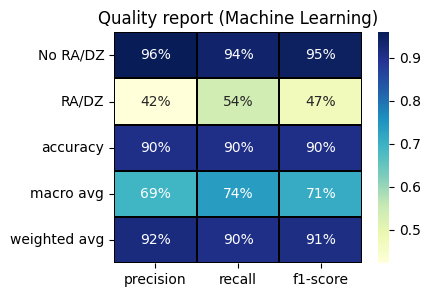

,feature,feature_per
69,cfm2,3.1%
94,cfm3,3.0%
45,cft1,2.7%
20,cft0,2.6%
44,cfm1,2.5%
95,cft3,2.4%
18,cfl0,2.3%
43,cfl1,2.3%
46,HGT5001,2.0%
68,cfl2,2.0%


Round 4


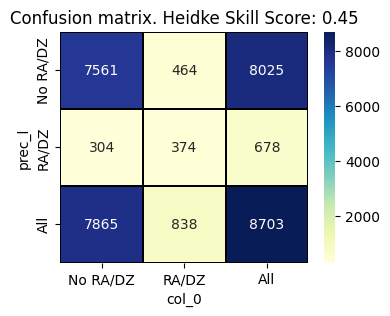

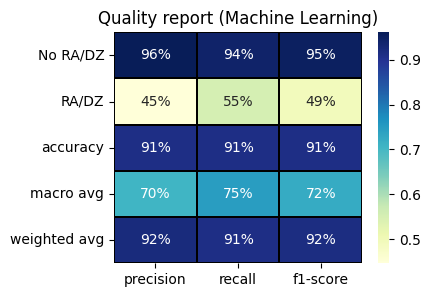

,feature,feature_per
95,cft3,3.2%
68,cfl2,2.9%
45,cft1,2.9%
69,cfm2,2.8%
94,cfm3,2.5%
19,cfm0,2.5%
43,cfl1,2.4%
93,cfl3,2.4%
20,cft0,2.3%
18,cfl0,2.1%


Round 5


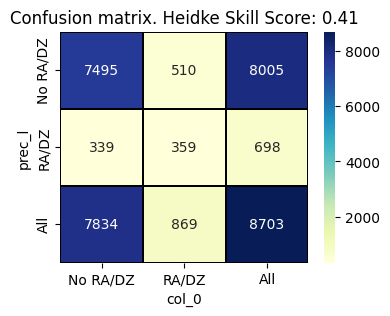

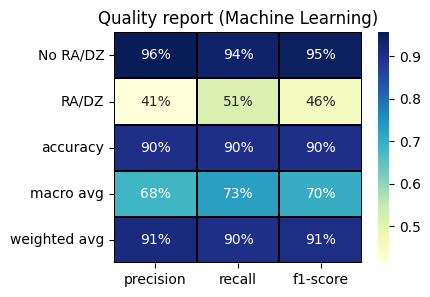

,feature,feature_per
45,cft1,2.9%
19,cfm0,2.8%
18,cfl0,2.7%
69,cfm2,2.7%
94,cfm3,2.6%
68,cfl2,2.6%
43,cfl1,2.4%
95,cft3,2.2%
70,cft2,2.1%
71,HGT5002,2.1%


Round 6


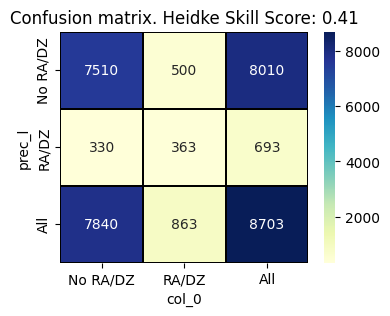

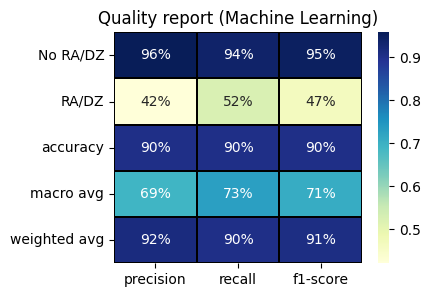

,feature,feature_per
20,cft0,3.3%
94,cfm3,2.7%
43,cfl1,2.7%
18,cfl0,2.5%
19,cfm0,2.3%
44,cfm1,2.2%
69,cfm2,2.2%
45,cft1,2.1%
95,cft3,2.1%
93,cfl3,2.0%


Round 7


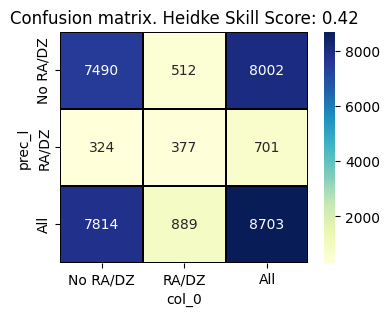

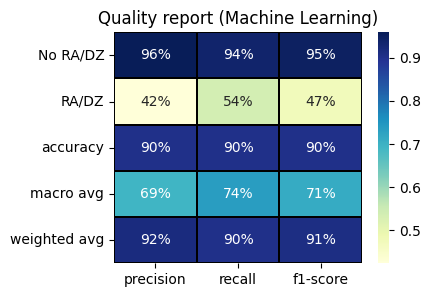

,feature,feature_per
18,cfl0,3.0%
44,cfm1,2.9%
20,cft0,2.9%
94,cfm3,2.8%
45,cft1,2.7%
43,cfl1,2.5%
19,cfm0,2.2%
68,cfl2,2.2%
93,cfl3,2.1%
71,HGT5002,2.0%


Round 8


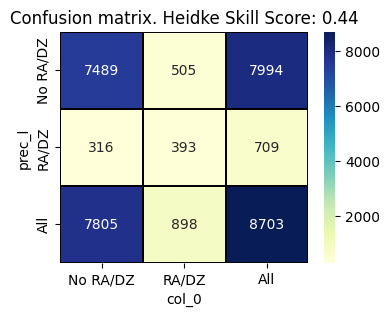

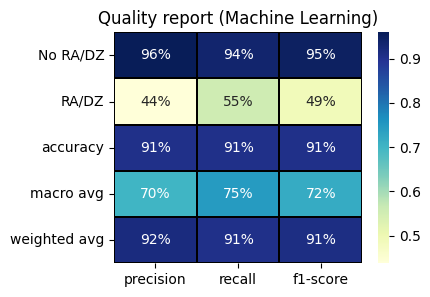

,feature,feature_per
19,cfm0,3.0%
43,cfl1,2.7%
94,cfm3,2.5%
45,cft1,2.4%
20,cft0,2.4%
93,cfl3,2.4%
68,cfl2,2.4%
18,cfl0,2.3%
95,cft3,2.2%
69,cfm2,2.1%


Round 9


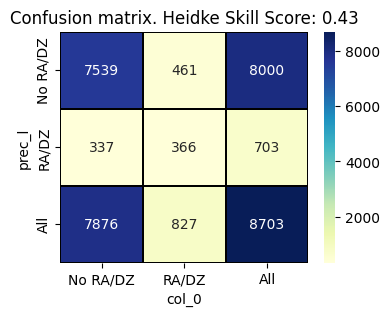

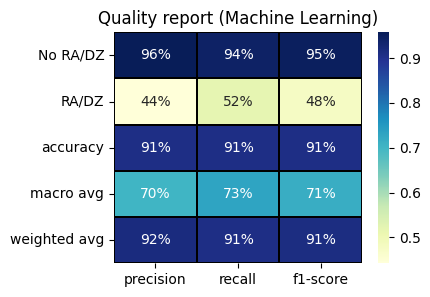

,feature,feature_per
69,cfm2,3.7%
44,cfm1,3.0%
70,cft2,2.8%
18,cfl0,2.7%
95,cft3,2.6%
45,cft1,2.5%
20,cft0,2.5%
43,cfl1,2.2%
19,cfm0,1.9%
68,cfl2,1.8%



HSS stadistics
             HSS
count  10.000000
mean    0.430393
std     0.014927
min     0.405299
25%     0.421645
50%     0.432321
75%     0.437566
max     0.455399
Shapiro test normality
p value: 0.9872547388076782
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1605.5135814445318
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 4.58 minutes


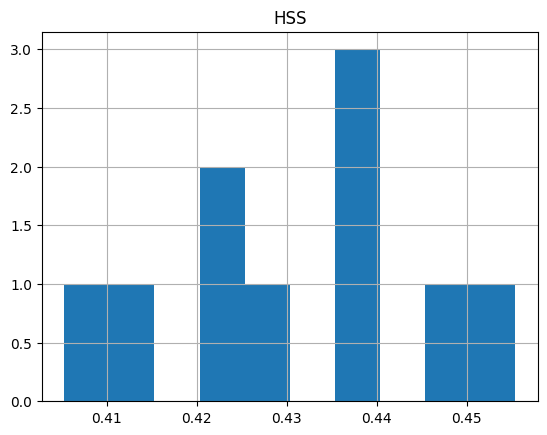

In [24]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()
  
  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage) 
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples") 



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LECO/algorithms/prec_LECO_d1.al", 'wb'))